In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [3]:
# 数据
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0,
                    3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
# 归一化输入
t_un = 0.1 * t_u

In [4]:
# 模型
def model(t_u, w, b):
    return w * t_u + b

In [5]:
# 损失函数
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [6]:
# 初始化一个参数张量
params = torch.tensor([1.0,0.0], requires_grad=True)

`requires_grad=True`参数告诉 PyTorch 跟踪由对params 张量进行操作后产生的张量的整个系谱树。换句话说，任何将 params 作为祖先的张量都可以访问从 params 到那个张量调用的函数链。如果这些函数是可微的（大多数 PyTorch 张量操作都是可微的），导数的值将自动填充为 params 张量的 grad 属性。

通常，所有 PyTorch 张量都有一个名为 grad 的属性。通常情况下，该属性值为 None：

In [7]:
params.grad is None

True

我们所要做的就是从一个 requires_grad 为 True 的张量开始，调用模型并计算损失，然后反向调用损失张量：

In [9]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

此时， params 的 grad 属性包含关于 params 的每个元素的损失的导数。

当我们计算损失时，参数 w 和 b 需要计算梯度。除了执行实际的计算外， PyTorch 还创建了以操作（黑色圆圈）为节点的自动求导图，如图 5.10 上部所示。当我们调用 loss.backward()时，PyTorch 将反向遍历此图以计算梯度，如图 5.10 下部所示。

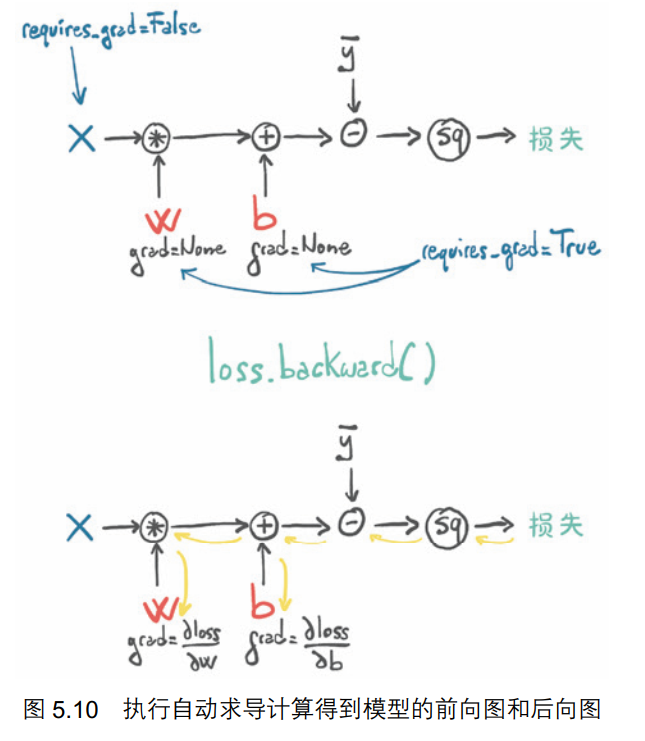

注意：调用 backward()将导致导数在叶节点上累加。使用梯度进行参数更新后，我们需要显式地将梯度归零。因此如果提前调用backward()，则会再次计算损失，再次调用 backward()（就像在任何训练循环中一样），每个叶节
点上的梯度将在上一次迭代中计算的梯度之上累加（求和），这会导致梯度计算不正确

为了防止这种情况发生，我们需要在每次迭代时明确地将梯度归零。我们可以就地使用zero()_方法轻松地完成这一任务：

In [10]:
if params.grad is not None:
    params.grad.zero_()

In [13]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: # 这可以在循环中调用 loss.backward()之前的任何时间完成
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

注意， params 并不像我们预期的那样简单，其有 2 个特殊性。

首先，我们使用 Python 的 with语句将更新封装在非梯度上下文中，这意味着在 with 块中， PyTorch 自动求导机制将不起作用：也就是说，不向前向图添加边。实际上，当我们执行这段代码时， PyTorch 记录的前向图在我们调用 backward()时被消费掉，留下 params 叶节点。但是现在我们想在叶节点建立一个新的前向图之前改变它。

其次，我们在适当的地方更新 params 张量，这意味着我们保持相同的 params 张量但从中减去更新。当使用自动求导时，我们通常避免就地更新，因为 PyTorch 的自动求导引擎可能需要我们修改反向传播的值。然而，在这里，我们没有自动求导操作，保持 params 张量是有益的。

In [14]:
training_loop(n_epochs=5000,
              learning_rate=1e-2,
              params=torch.tensor([1.0,0.0], requires_grad=True),
              t_u = t_un,
              t_c=t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

结果和我们之前得到的是一样的。这意味着，虽然我们有能力手动计算导数，但我们不再需要这样做。